In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="点击此处切换是否显示源代码"></form>''')

# 数字水印——稳健盲水印嵌入

# 项目背景

## 水印处理系统的框架

给出图像 $X_0$ 和水印密钥 $K$ (比如，水印嵌入的位置)，使用生成算法 $G$ 生成待嵌入的的水印 $W=G(X_0,K)$，然后使用嵌入算法 $E$ 生成图片 $X_w=E(X_0,W)$。而检测算法 $D:X\times K\rightarrow \{0,1\}$ 则可以检测是否存在对应的水印。

## 水印的分类

- 可见(Perceptible)/不可见(Inperceptible): 即人类的感知系统 (Human Visual System, HVS) 能否感知到水印的存在

- 脆弱(Fragile)/稳健(Robust): 脆弱水印可以检测出载体是否被修改，可用于完整性检验等; 稳健水印则再载体经过信号处理或恶意攻击后仍能被检测出来，可用于版权保护等。

- 非盲(Noblind)/半盲(Seminonblind)/全盲(Blind): 检测水印的过程中需要 $X_0,W$ 的参与称为非盲水印。无需 $X_0$ 但需要 $W$ 称为半盲水印。只需要 $K$ 的称为全盲水印。

- 空域(Spatial)/变换域(Transform): 水印嵌入的位置。常见的变换域方法包括离散余弦变换 (Discrete Cosine Transform, DCT), 离散小波变换 (Discrete Wavelet Transform, DWT) 和离散傅里叶变换 (Discrete Fourier Transform, DFT)

## 水印的攻击

水印可能会遭受下列的攻击

### 无意的攻击

- 低通滤波 (中值、高斯、均值等)
- Gamma 矫正
- 直方图修正
- 图像压缩

### 有意的攻击

- 翻转
- 剪切
- 旋转
- 尺度变换(一致/非一致)
- 随机行/列删除
- 随机几何失真(模拟打印后扫描的结果)
- 噪声攻击

## 评价的指标

- MSE(Mean Square Error)：原水印和提取水印的均方误差。MSE越低说明我们的水印还原得越好。

  $M S E = \frac { 1 } { x y } \sum _ { a = 0 } ^ { x - 1 } \sum _ { b = 0 } ^ { y - 1 } [ A ( a , b ) - K ( a , b ) ] ^ { 2 }$

- PSNR(Peak Signal to Noise Ratio)：原始图像和加水印后图像的峰值信噪比。图像的 PSNR 越高，说明我们的水印越不容易被感知。

  $PSNR=10\cdot \log_{10}\left(\frac{255}{\sqrt{MSE}}\right)$ (注：这里的 $MSE$ 是原始图像和加水印后图像的$MSE$)

- SR(Similarity Factor): 另一个刻画原水印和提取水印相似度的计算方式，通常转成向量后点积求余弦相似度

  $S F \left( A , A ^ { \prime } \right) = \frac { A ^ { * } A ^ { \prime } } { \sqrt { A ^ { \prime * } A ^ { \prime } } }$

## 我们实现了

- DFT 非盲水印的嵌入

- DWT 盲水印的嵌入

- DCT 盲水印的嵌入

  - 量化方法：直接修改为 -1/1
  
  - 量化方法：根据 0/1 量化至奇/偶
  
  - 量化方法：使用 0/1 伪随机序列
  
- DWT+DCT 盲水印的嵌入

- DWT+SVD 盲水印的嵌入

- 空域盲水印嵌入

- 混合盲水印嵌入

- 相关的稳健性测试


# 实验代码

## 实验前的准备

### 加载相关库和图片，以及部分基础的功能函数

一个标准的二维码是 35\*35 的 0-1 点阵，由于有三个角只是为了方便定位而没有包含基本信息，我们对二维码进行了进一步的压缩，每个二维码含有 897 bit 的信息。

897


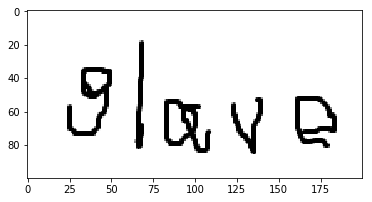

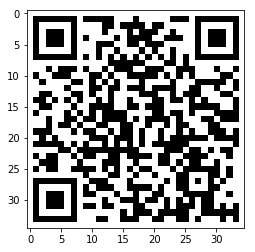

In [2]:
import numpy as np
from scipy.fftpack import fft2, ifft2, dct, idct
import matplotlib.pyplot as plt
import pywt
import cv2
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

img = plt.imread('./image/origin.png')
origin_watermark = plt.imread('./image/watermark.png')
binary_watermark = np.loadtxt('./qrcode.txt', dtype=int) // 255

corner = np.zeros((9, 9), dtype=np.uint8)
corner[0, :] = 1
corner[8, :] = 1
corner[:, 0] = 1
corner[:, 8] = 1
corner[2, 2:7] = 1
corner[6, 2:7] = 1
corner[3:6, 2] = 1
corner[3:6, 6] = 1


def qrcode2series(qrcode):  # thr corner in qrcord
    idx = 0
    series = np.zeros(897)
    for i in range(1, 9):
        for j in range(9, 26):
            series[idx] = qrcode[i, j]
            idx += 1
    for i in range(9, 26):
        for j in range(1, 34):
            series[idx] = qrcode[i, j]
            idx += 1
    for i in range(26, 34):
        for j in range(9, 34):
            series[idx] = qrcode[i, j]
            idx += 1
    return series


def series2qrcode(series):
    qrcode = np.ones((35, 35))
    qrcode[0:9, 0:9] = corner
    qrcode[0:9, 26:35] = corner
    qrcode[26:35, 0:9] = corner
    idx = 0
    for i in range(1, 9):
        for j in range(9, 26):
            qrcode[i, j] = series[idx]
            idx += 1
    for i in range(9, 26):
        for j in range(1, 34):
            qrcode[i, j] = series[idx]
            idx += 1
    for i in range(26, 34):
        for j in range(9, 34):
            qrcode[i, j] = series[idx]
            idx += 1
    return qrcode


def show_imgs(fig, img, img_marked, img_attacked, watermark, reconstruct):
    fig.add_subplot(1, 5, 1)
    plt.title('marked img', fontsize=24)
    plt.imshow(img_marked)
    fig.add_subplot(1, 5, 2)
    plt.title('attacked img', fontsize=24)
    plt.imshow(img_attacked)
    fig.add_subplot(1, 5, 3)
    plt.title('marked residual', fontsize=24)
    plt.imshow(np.abs(img_marked - img))
    fig.add_subplot(1, 5, 4)
    plt.title('extracted', fontsize=24)
    plt.imshow(reconstruct, cmap='gray')
    fig.add_subplot(1, 5, 5)
    plt.title('extracted residual', fontsize=24)
    plt.imshow(np.abs(reconstruct - watermark), cmap='gray')
    plt.show()


series_1_4 = np.array([1, 0, 0, 1, 0])  # for block_size == 4
series_1_8 = np.array([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
                       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1])  # for block_size == 8

print(len(qrcode2series(binary_watermark)))
plt.imshow(origin_watermark)
plt.show()
plt.imshow(binary_watermark, cmap='gray')
plt.show()

### 定义了评价指标MSE和PSNR

In [3]:
def MSE(A, B):
    return np.mean(np.power(A-B, 2))


def PSNR(A, B):
    return 10 * np.log10(255 / np.sqrt(MSE(A, B)))

### 定义了常见的攻击类型

In [4]:
def no_attack(img):
    return img.copy()


def erase_attack(img):
    ret = img.copy()
    ret[img.shape[0]*3//4:img.shape[0], img.shape[1]*3//4:img.shape[1], :] = 1
    return ret


def gaussian_attack(img, intensity):
    ret = img.copy()
    ret += np.random.normal(0, intensity, ret.shape)
    return ret


def salt_pepper(img, n, salt):
    ret = img.copy()
    val = 1 if salt else 0
    for k in range(n):
        i = int(np.random.random() * img.shape[0])
        j = int(np.random.random() * img.shape[1])
        ret[i, j, :] = val
    return ret


def jpeg_attack(img, block_size=8):
    marked = img.copy()
    channel_size = 3
    dim1 = (img.shape[0] // block_size)
    dim2 = (img.shape[1] // block_size)
    for x in range(dim1):
        for y in range(dim2):
            for channel in range(channel_size):
                coef = dct2(img[x*block_size:x*block_size+block_size,
                                y*block_size:y*block_size+block_size, channel])
                for i in range(block_size):
                    for j in range(max(0, block_size-1-i), block_size):
                        coef[i, j] = 0
                marked[x*block_size:x*block_size+block_size,
                       y*block_size:y*block_size+block_size, channel] = idct2(coef)
    return marked


def hist_attack(img):
    ret = (img.copy()[:, :, (2, 1, 0)] * 256).astype(np.uint8)
    img_yuv = cv2.cvtColor(ret, cv2.COLOR_BGR2YCrCb)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2BGR)
    return img_output[:, :, (2, 1, 0)] / 256


def color_attack(img, channel):
    ret = img.copy()
    ret[:, :, channel] = cv2.equalizeHist(
        (256 * ret[:, :, channel]).astype(np.uint8)) / 256
    return ret

# and some others attack defined in opencv
# cv2.medianBlur(img01,5)
# cv2.blur(img01,(5,5))
# cv2.GaussianBlur(img01,(7,7),0)
# cv2.bilateralFilter(img01,40,75,75)

## 水印嵌入算法

### DFT 非盲水印嵌入

DFT 非盲水印嵌入的想法十分简单，对于图片 $I$ 先进行 DFT 得到频谱图 $F$，然后将待嵌入的水印图像 $W$ 直接叠加上去得到 $F'=F+\omega W$，随后进行 IDFT 得到带水印的图像 $I'$。提取水印则基本上是上过程的逆过程——先对 $I,I'$ 做 DFT 得到 $F,F'$，随即通过 $(F'-F)/\omega$ 得到水印的图像 $W$。

在这一过程中，可以通过调整叠加水印图像的权重 $\omega$ 平衡图像质量和水印的稳健性。实现的代码如下。三张结果图分别代表嵌入后的图像，嵌入后的图像对比原图像的残差以及提取出的水印。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


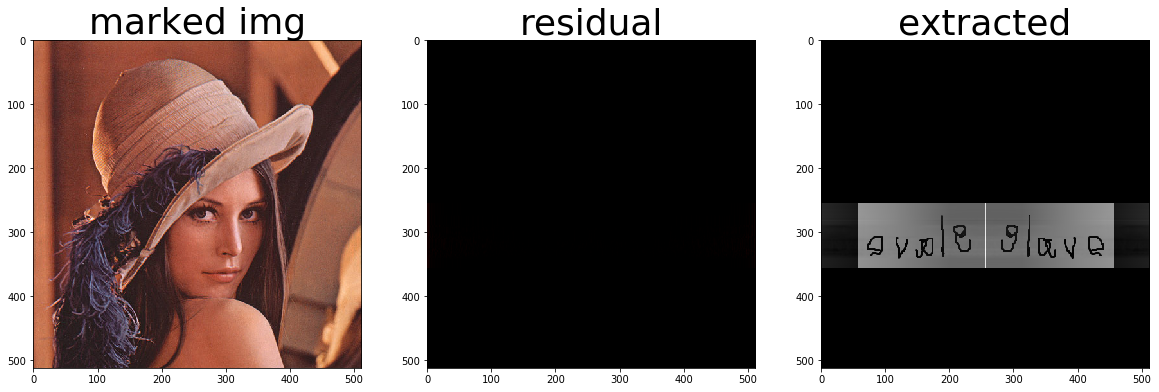

In [5]:
def DFT_add_watermark(img, watermark, weight=1):
    mask = np.zeros(img.shape)
    mask[:watermark.shape[0], :watermark.shape[1], :] = watermark
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    img_fft += mask * weight
    img_marked = np.fft.ifft2(np.fft.ifftshift(img_fft))
    return np.abs(img_marked)


def DFT_extract_watermark(img_marked, img):
    return np.abs(fft2(img_marked) - fft2(img))


def DFT_test(img, watermark):
    img_marked = DFT_add_watermark(img, watermark, 1)
    img_extracted = DFT_extract_watermark(img_marked, img)
    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 3, 1)
    plt.title('marked img', fontsize=36)
    plt.imshow(img_marked)
    fig.add_subplot(1, 3, 2)
    plt.title('residual', fontsize=36)
    plt.imshow(np.abs(img_marked - img))
    fig.add_subplot(1, 3, 3)
    plt.title('extracted', fontsize=36)
    plt.imshow(img_extracted)
    plt.show()


DFT_test(img, origin_watermark)

### DWT 非盲水印嵌入

DWT 的原理这里不再赘述。其会将 $n\times n$ 的图片在 $x,y$ 方向分别提取出低频和高频成分，组合成 4 张 $n/2\times n/2$ 的图片，分别代表 $LL,LH,HL,HH$。由于 $LL$ 包含大量信息无法直接嵌入，而 $HH$ 相对稳健性较差，实际使用中通常选择 $HL$ 或 $LH$ 较多。但在这个非盲的例子下我们直接使用 $HH$ 带作为演示。

同样这里也可以根据嵌入的权重来平衡图像质量和水印稳健性。实验的代码如下，三张结果图分别代表嵌入后的图像，嵌入后的图像对比原图像的残差以及提取出的水印。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


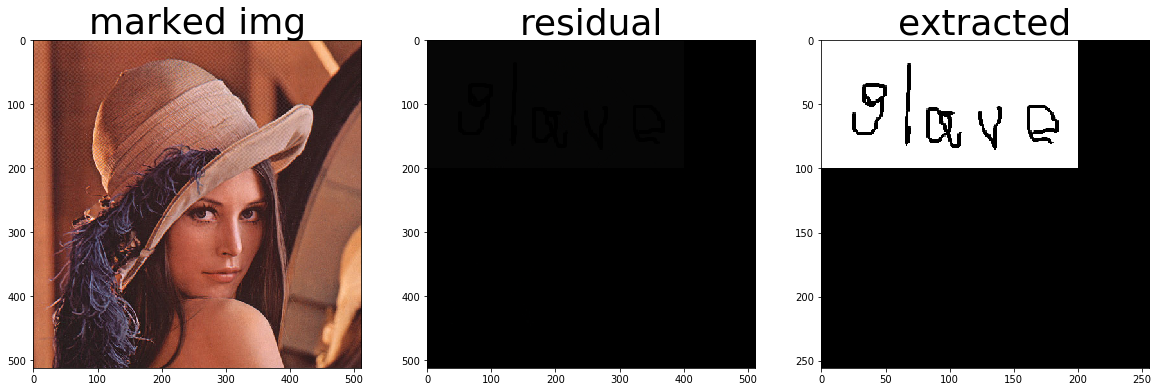

In [6]:
def DWT_add_watermark(img, watermark, weight=0.05):
    mask = np.zeros((img.shape[0]//2, img.shape[1]//2, img.shape[2]))
    mask[:watermark.shape[0], :watermark.shape[1], :] = watermark
    (LL, (LH, HL, HH)) = pywt.dwt2(img, 'haar', axes=(0, 1))
    coef = (LL, (LH, HL, HH * (1-weight) + mask * weight))
    return pywt.idwt2(coef, 'haar', axes=(0, 1))


def DWT_extract_watermark(img_marked, img, weight=0.05):
    return (pywt.dwt2(img_marked, 'haar', axes=(0, 1))[1][2] - (1-weight) * pywt.dwt2(img, 'haar', axes=(0, 1))[1][2])


def DWT_test(img, watermark):
    img_marked = DWT_add_watermark(img, watermark, 0.05)
    img_extracted = DWT_extract_watermark(img_marked, img)
    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 3, 1)
    plt.title('marked img', fontsize=36)
    plt.imshow(img_marked)
    fig.add_subplot(1, 3, 2)
    plt.title('residual', fontsize=36)
    plt.imshow(np.abs(img_marked - img))
    fig.add_subplot(1, 3, 3)
    plt.title('extracted', fontsize=36)
    plt.imshow(np.abs(img_extracted * 100))
    plt.show()


DWT_test(img, origin_watermark)

### DCT 盲水印嵌入(量化至奇/偶)

DCT 盲水印的核心思想，均是先对原图像进行分割（如 $4\times 4$ 或 $8\times 8$)，然后分块进行 DCT 得到系数阵，并通过某种量化方式将信息写入在系数阵上。

量化至奇/偶，顾名思义就是根据改写如的信息是 0 或 1 选择将对应的数字往最近的奇数/偶数取整。这里需要注意的有两点

- 事实上，绝大多数系数可能都会比较接近0，因此量化之时通常会乘一个放大系数 $Q$。该放大系数自然也就承担了平衡图像质量和水印稳健性的功能。
- 我们通常处理 DCT 系数的中低频部分，因为图像的能量大都集中在低频部分，对低频修改可能会使得图像质量下降较大。而高频成分则相对更不稳定，且许多图像压缩算法如 JPEG 就是对 DCT 系数丢弃高频然后量化后实现了高质量的压缩。

而提取的时候则重复同样的操作，将嵌入位置的值(乘上相同的量化系数后)进行取整，根据奇数多还是偶数多决定 0/1。

实现的代码如下。五张结果图分别代表嵌入后的图像、嵌入后的图像对比原图像的残差、攻击后的图像、提取出的水印以及提取的水印相对原水印的残差。这里由于 DCT 嵌入的时候没有嵌入到右下角，所以对右下角的裁剪完全不敏感。这个十分朴素的例子其实也是有用的——许多网站会自动将可见的水印直接嵌入在左下角或者右下角，至少这样的方式通常不会对 DCT 的盲水印嵌入带来干扰

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


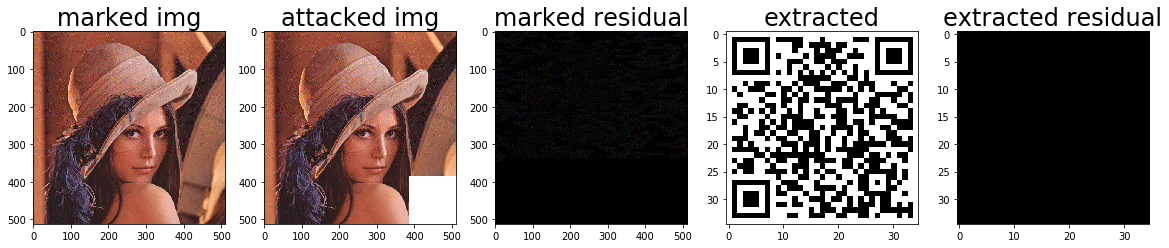

In [7]:
def my_round(x, toeven):
    if toeven:
        return np.round(x/2)*2
    else:
        return np.round((x + 1)/2)*2-1


def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')


def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')


def DCT_add_watermark(img, series, Q=1000, block_size=8):
    marked = img.copy()
    channel_size = 3
    dim1 = (img.shape[0] // block_size)
    dim2 = (img.shape[1] // block_size)
    max_capacity = dim1 * dim2
    if series.shape[0] > max_capacity:
        print("Cannot embbed the message")
    for i in range(series.shape[0]):
        x = (i // dim2) * block_size
        y = (i % dim2) * block_size
        for channel in range(channel_size):
            coef = dct2(img[x:x+block_size, y:y+block_size, channel])
            coef *= Q
            for freq in range(block_size // 2, block_size):
                for id in range(freq):
                    coef[id, freq - 1 -
                         id] = my_round(coef[id, freq - 1 - id], series[i] == 1)
            coef /= Q
            marked[x:x+block_size, y:y+block_size, channel] = idct2(coef)
    return marked


def DCT_extract_watermark(img_marked, series_len, Q=1000, block_size=8):
    channel_size = 3
    dim1 = (img_marked.shape[0] // block_size)
    dim2 = (img_marked.shape[1] // block_size)
    series = np.zeros(series_len)
    bit_every_block = channel_size * \
        (3 * block_size * block_size - 2 * block_size) // 8
    for i in range(series_len):
        x = (i // dim2) * block_size
        y = (i % dim2) * block_size
        votes = 0
        for channel in range(channel_size):
            coef = dct2(img_marked[x:x+block_size, y:y+block_size, channel])
            coef *= Q
            for freq in range(block_size // 2, block_size):
                for id in range(freq):
                    if np.round(coef[id, freq - 1 - id]) % 2 == 0:
                        votes += 1
        series[i] = votes
    return series / bit_every_block


def DCT_test(img, watermark, Q=1000, attack_method=no_attack, show=True, *args, **kwargs):
    series = qrcode2series(watermark)
    series = np.repeat(series, 3)
    img_marked = DCT_add_watermark(img, series, Q)
    img_attacked = attack_method(img_marked, *args, **kwargs)
    series2 = DCT_extract_watermark(img_attacked, series.shape[0], Q)
    series2 = np.round(
        np.mean(series2.reshape((series.shape[0]//3, 3)), axis=1))
    reconstruct = series2qrcode(series2)
    if show:
        fig = plt.figure(figsize=(20, 20))
        show_imgs(fig, img, img_marked, img_attacked, watermark, reconstruct)
    return img_marked, reconstruct


_ = DCT_test(img, binary_watermark, 10, erase_attack, True, *[])

### DCT 盲水印嵌入(量化为-1/1)

采用了一个更加激进的量化方式——（再乘上量化系数后）根据 0/1 直接修改系数为 -1/1，提取的时候则根据符号来决定还原为 0/1。可想而知这样的算法图像质量会较差但稳健性得到提高。

实现的代码如下。五张结果图分别代表嵌入后的图像、嵌入后的图像对比原图像的残差、攻击后的图像、提取出的水印以及提取的水印相对原水印的残差。从第一张图和第三张图可以看到格点。为此，这里接了一个中值滤波去除这样的类似椒盐的噪点。从第二张图和第四张图可以看到图像质量的改善。而盲水印对这样的中值滤波的攻击也有一定的抵抗能力——最后水印只出现了 1bit 的错误，这对于二维码的扫描完全不成问题。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


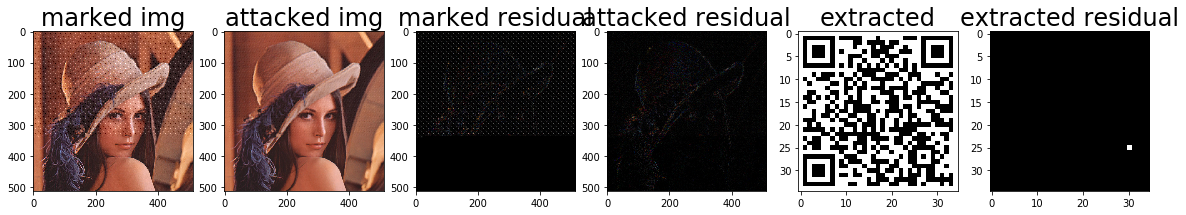

In [8]:
def impose(is_one):
    if is_one:
        return 1
    else:
        return -1


def DCT_add_watermark_impose(img, series, Q=1000, block_size=8):
    marked = img.copy()
    channel_size = 3
    dim1 = (img.shape[0] // block_size)
    dim2 = (img.shape[1] // block_size)
    max_capacity = dim1 * dim2
    if series.shape[0] > max_capacity:
        print("Cannot embbed the message")
    for i in range(series.shape[0]):
        x = (i // dim2) * block_size
        y = (i % dim2) * block_size
        for channel in range(channel_size):
            coef = dct2(img[x:x+block_size, y:y+block_size, channel])
            coef *= Q
            for freq in range(block_size // 2, block_size):
                for id in range(freq):
                    coef[id, freq - 1 - id] = impose(series[i] == 1)
            coef /= Q
            marked[x:x+block_size, y:y+block_size, channel] = idct2(coef)
    return marked


def DCT_extract_watermark_impose(img_marked, series_len, Q=1000, block_size=8):
    channel_size = 3
    dim1 = (img_marked.shape[0] // block_size)
    dim2 = (img_marked.shape[1] // block_size)
    series = np.zeros(series_len)
    bit_every_block = channel_size * \
        (3 * block_size * block_size - 2 * block_size) // 8
    for i in range(series_len):
        x = (i // dim2) * block_size
        y = (i % dim2) * block_size
        votes = 0
        for channel in range(channel_size):
            coef = dct2(img_marked[x:x+block_size, y:y+block_size, channel])
            coef *= Q
            for freq in range(block_size // 2, block_size):
                for id in range(freq):
                    if coef[id, freq - 1 - id] > 0:
                        votes += 1
        series[i] = votes
    return series / bit_every_block


def DCT_test_impose(img, watermark, Q=1000, attack_method=no_attack, show=True, *args, **kwargs):
    series = qrcode2series(watermark)
    series = np.repeat(series, 3)
    img_marked = DCT_add_watermark_impose(img, series, Q)
    img_attacked = attack_method(img_marked, *args, **kwargs)
    series2 = DCT_extract_watermark_impose(img_attacked, series.shape[0], Q)
    series2 = np.round(
        np.mean(series2.reshape((series.shape[0]//3, 3)), axis=1))
    reconstruct = series2qrcode(series2)
    if show:
        fig = plt.figure(figsize=(20, 20))
        fig.add_subplot(1, 6, 1)
        plt.title('marked img', fontsize=24)
        plt.imshow(img_marked)
        fig.add_subplot(1, 6, 2)
        plt.title('attacked img', fontsize=24)
        plt.imshow(img_attacked)
        fig.add_subplot(1, 6, 3)
        plt.title('marked residual', fontsize=24)
        plt.imshow(np.abs(img_marked - img))
        fig.add_subplot(1, 6, 4)
        plt.title('attacked residual', fontsize=24)
        plt.imshow(np.abs(img_attacked - img))
        fig.add_subplot(1, 6, 5)
        plt.title('extracted', fontsize=24)
        plt.imshow(reconstruct, cmap='gray')
        fig.add_subplot(1, 6, 6)
        plt.title('extracted residual', fontsize=24)
        plt.imshow(np.abs(reconstruct - watermark), cmap='gray')
        plt.show()
    return img_marked, reconstruct


_ = DCT_test_impose(img, binary_watermark, 10, cv2.medianBlur, True, *[3])

### DCT 盲水印嵌入(量化为伪随机序列)

使用一段预先给出了伪随机序列来作为量化时的目标。当信息为 0/1 时分别量化为该随机序列或其补。提取水印时根据相关系数来得到该信息是 0/1.

实现的代码如下。五张结果图分别代表嵌入后的图像、嵌入后的图像对比原图像的残差、JPEG 压缩攻击后的图像、提取出的水印以及提取的水印相对原水印的残差。可以看到图像质量相比直接量化为 -1/1 有提升。

这里由于选用了 JPEG 压缩攻击，而基于 DCT 对齐天然地不敏感。这个十分朴素的例子同样其实也是有用的——在互联网上使用 JPEG 这样格式的图片是十分常见的。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


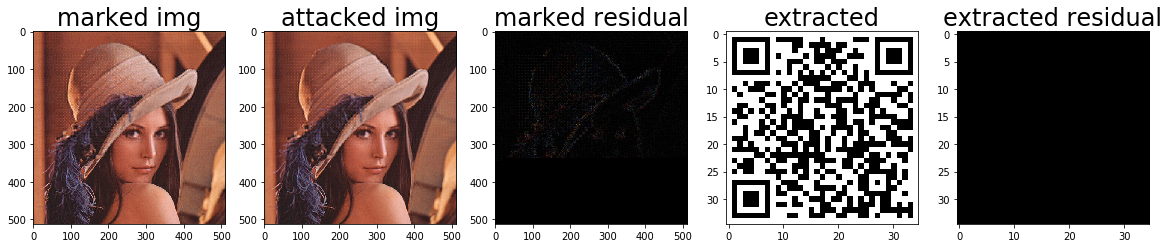

In [9]:
def DCT_add_watermark_corr(img, series, Q=1000, block_size=8):
    series_1 = series_1_4 if block_size == 4 else series_1_8
    marked = img.copy()
    channel_size = 3
    dim1 = (img.shape[0] // block_size)
    dim2 = (img.shape[1] // block_size)
    max_capacity = dim1 * dim2
    if series.shape[0] > max_capacity:
        print("Cannot embbed the message")
    for i in range(series.shape[0]):
        x = (i // dim2) * block_size
        y = (i % dim2) * block_size
        for channel in range(channel_size):
            coef = dct2(img[x:x+block_size, y:y+block_size, channel])
            coef *= Q
            cnt = 0
            for freq in range(block_size // 2, block_size):
                for id in range(freq):
                    coef[id, freq - 1 -
                         id] = series_1[cnt] if series[i] == 1 else 1-series_1[cnt]
                    cnt += 1
            coef /= Q
            marked[x:x+block_size, y:y+block_size, channel] = idct2(coef)
    return marked


def DCT_extract_watermark_corr(img_marked, series_len, Q=1000, block_size=8):
    series_1 = series_1_4 if block_size == 4 else series_1_8
    channel_size = 3
    dim1 = (img_marked.shape[0] // block_size)
    dim2 = (img_marked.shape[1] // block_size)
    series = np.zeros(series_len)
    bit_every_block = (3 * block_size * block_size - 2 * block_size) // 8
    for i in range(series_len):
        x = (i // dim2) * block_size
        y = (i % dim2) * block_size
        corrs = 0.0
        for channel in range(channel_size):
            coef = dct2(img_marked[x:x+block_size, y:y+block_size, channel])
            coef *= Q
            tmp = np.zeros(bit_every_block)
            cnt = 0
            for freq in range(block_size // 2, block_size):
                for id in range(freq):
                    tmp[cnt] = coef[id, freq - 1 - id]
                    cnt += 1
            corrs += np.corrcoef(series_1, tmp)[0, 1]
        series[i] = 1 if corrs > 0 else 0
    return series


def DCT_test_corr(img, watermark, Q=1000, attack_method=no_attack, show=True, *args, **kwargs):
    series = qrcode2series(watermark)
    series = np.repeat(series, 3)
    img_marked = DCT_add_watermark_corr(img, series, Q)
    img_attacked = attack_method(img_marked, *args, **kwargs)
    series2 = DCT_extract_watermark_corr(img_attacked, series.shape[0], Q)
    series2 = np.round(
        np.mean(series2.reshape((series.shape[0]//3, 3)), axis=1))
    reconstruct = series2qrcode(series2)
    if show:
        fig = plt.figure(figsize=(20, 20))
        show_imgs(fig, img, img_marked, img_attacked, watermark, reconstruct)
    return img_marked, reconstruct


_ = DCT_test_corr(img, binary_watermark, 25, jpeg_attack, True, *[])

### DWT+DCT 盲水印嵌入

比起直接对原图像进行分块然后 DCT，该方法先对图像做一次 DWT，然后取 $HL$ 带作为 DCT 嵌入的目标。因此可以在 DCT 的步骤使用质量更低而更稳健的嵌入方式。

这里五张图的意义和之前一样就不再赘述了。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


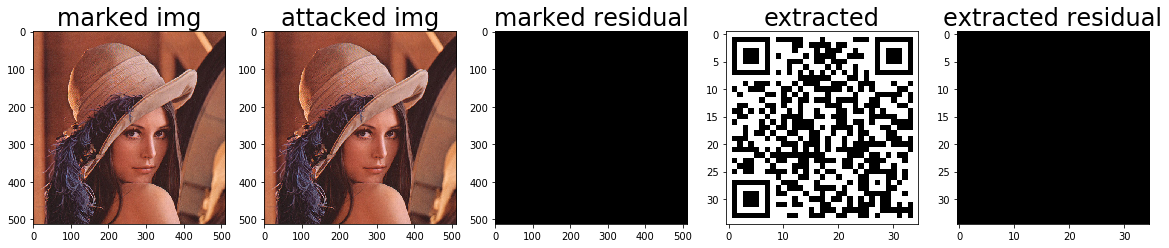

In [10]:
def DWT_DCT_add_watermark(img, series, Q=1000, block_size=8):
    (LL, (LH, HL, HH)) = pywt.dwt2(img, 'haar', axes=(0, 1))
    (LL2, (LH2, HL2, HH2)) = pywt.dwt2(HL, 'haar', axes=(0, 1))
    HL2_ = DCT_add_watermark(HL2, series, Q, block_size)
    HL_ = pywt.idwt2((LL2, (LH2, HL2_, HH2)), 'haar', axes=(0, 1))
    img_ = pywt.idwt2((LL, (LH, HL_, HH)), 'haar', axes=(0, 1))
    return img_


def DWT_DCT_extract_watermark(img_marked, series_len, Q=1000, block_size=8):
    (LL, (LH, HL, HH)) = pywt.dwt2(img_marked, 'haar', axes=(0, 1))
    (LL2, (LH2, HL2, HH2)) = pywt.dwt2(HL, 'haar', axes=(0, 1))
    series = DCT_extract_watermark(HL2, series_len, Q, block_size)
    return series


def DWT_DCT_test(img, watermark, Q=1000, attack_method=no_attack, show=True, *args, **kwargs):
    series = qrcode2series(watermark)
    img_marked = DWT_DCT_add_watermark(img, series, Q, 4)
    img_attacked = attack_method(img_marked, *args, **kwargs)
    series2 = DWT_DCT_extract_watermark(img_attacked, series.shape[0], Q, 4)
    reconstruct = series2qrcode(series2)
    if show:
        fig = plt.figure(figsize=(20, 20))
        show_imgs(fig, img, img_marked, img_attacked, watermark, reconstruct)
    return img_marked, reconstruct


_ = DWT_DCT_test(img, binary_watermark)

### DCT +SVD 盲水印嵌入

其实该方法也可以作为一种量化方式——相比直接对系数矩阵进行修改，他对该系数矩阵先做 SVD 分解，然后选择第一个奇异值进行量化修改，最后再还原回系数矩阵，再通过 IDCT 得到嵌入后的图像。提取的方式也就是上述过程的逆过程。

这里五张图的意义和之前一样就不再赘述了。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


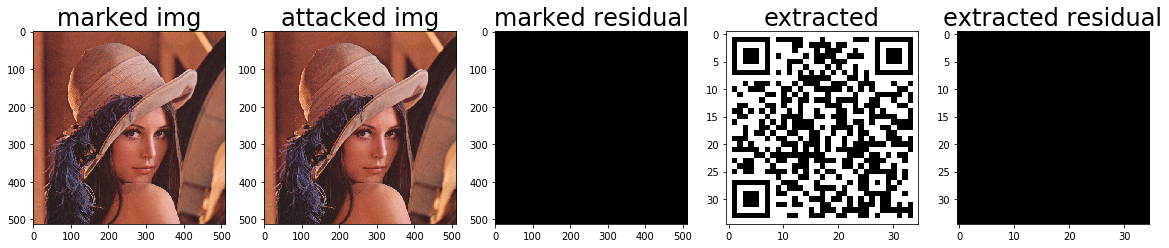

In [11]:
def DCT_SVD_add_watermark(img, series, Q=1000):
    marked = img.copy()
    A = np.zeros((128, 128, 3))
    series_len = series.shape[0]
    for i in range(128):
        for j in range(128):
            for channel in range(3):
                coef = dct2(img[4*i:4*i+4, 4*j:4*j+4, channel])
                A[i, j, channel] = coef[0, 0]
    for idx in range(series_len):
        i = idx // 32
        j = idx % 32
        for channel in range(3):
            u, s, vh = np.linalg.svd(
                A[4*i:4*i+4, 4*j:4*j+4, channel], full_matrices=False)
            s[0] = my_round(s[0] * Q, series[idx] == 1) / Q
            A[4*i:4*i+4, 4*j:4*j+4, channel] = np.dot(u * s, vh)
    for i in range(128):
        for j in range(128):
            for channel in range(3):
                coef = dct2(img[4*i:4*i+4, 4*j:4*j+4, channel])
                coef[0, 0] = A[i, j, channel]
                marked[4*i:4*i+4, 4*j:4*j+4, channel] = idct2(coef)
    return marked


def DCT_SVD_extract_watermark(img_marked, series_len, Q=1000):
    A = np.zeros((128, 128, 3))
    series = np.zeros(series_len)
    for i in range(128):
        for j in range(128):
            for channel in range(3):
                coef = dct2(img_marked[4*i:4*i+4, 4*j:4*j+4, channel])
                A[i, j, channel] = coef[0, 0]
    for idx in range(series_len):
        i = idx // 32
        j = idx % 32
        votes = 0
        for channel in range(3):
            u, s, vh = np.linalg.svd(
                A[4*i:4*i+4, 4*j:4*j+4, channel], full_matrices=False)
            if np.round(s[0] * Q) % 2 == 0:
                votes += 1
        if votes > 1.5:
            series[idx] = 1
        else:
            series[idx] = 0
    return series


def DCT_SVD_test(img, watermark, Q=1000, attack_method=no_attack, show=True, *args, **kwargs):
    series = qrcode2series(watermark)
    img_marked = DCT_SVD_add_watermark(img, series, Q)
    img_attacked = attack_method(img_marked, *args, **kwargs)
    series2 = DCT_SVD_extract_watermark(img_attacked, series.shape[0], Q)
    reconstruct = series2qrcode(series2)
    if show:
        fig = plt.figure(figsize=(20, 20))
        show_imgs(fig, img, img_marked, img_attacked, watermark, reconstruct)
    return img_marked, reconstruct


_ = DCT_SVD_test(img, binary_watermark)

### 空域盲水印嵌入

同样我们也提出并实现了一个空域盲水印的嵌入算法。其思想首先借鉴了 DCT 中分块处理的思想——将图像划分为 $8\times 8$ 的小块，然后在每个小块里面找最适合嵌入的 $2\times 2$ 区域——这里我选取的是方差最小的区域。然后将这个 $2\times 2$ 的区域量化至最近的偶数或者奇数（取决于 0/1）。提取时也十分自然——对于每个 $8\times 8$ 的块寻找方差最小的 $2\times 2$ 的区域，然后根据取整后的奇偶性立得我们嵌入的信息。

这里五张图的意义和之前一样就不再赘述了。

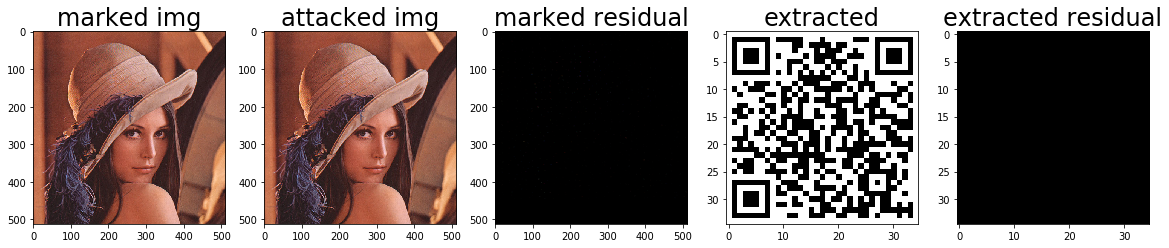

In [12]:
def find_best_window(img, window_size):
    param = (-1, -1, 100000)
    for i in range(img.shape[0] - window_size):
        for j in range(img.shape[1] - window_size):
            tmp = img[i:i+window_size, j:j+window_size, :]
            score = np.sum(np.std(tmp, axis=(0, 1)))
            if score < param[2]:
                param = (i, j, score)
    return param


def spatial_add_watermark(img, series, Q=1000):
    marked = img.copy()
    window_size = 4
    block_size = 16
    block_every_row = img.shape[0] // block_size
    series_len = series.shape[0]
    for idx in range(series_len):
        i = idx // block_every_row
        j = idx % block_every_row
        _x = i * block_size
        _y = j * block_size
        (x, y, _) = find_best_window(
            marked[_x:_x+block_size, _y:_y+block_size, :], window_size)
        mu = my_round(Q * np.mean(marked[_x+x:_x+x+window_size, _y +
                                         y:_y+y+window_size, :], axis=(0, 1)), series[idx] == 1) / Q
        marked[_x+x:_x+x+window_size, _y+y:_y+y+window_size, :] = np.repeat(
            mu, window_size * window_size).reshape((window_size, window_size, 3), order='F')
    return marked


def spatial_extract_watermark(img_marked, series_len, Q=1000):
    series = np.zeros(series_len)
    window_size = 4
    block_size = 16
    block_every_row = img_marked.shape[0] // block_size
    for idx in range(series_len):
        i = idx // block_every_row
        j = idx % block_every_row
        _x = i * block_size
        _y = j * block_size
        (x, y, _) = find_best_window(
            img_marked[_x:_x+block_size, _y:_y+block_size, :], window_size)
        mu = np.round(
            Q * np.mean(img_marked[_x+x:_x+x+window_size, _y+y:_y+y+window_size, :], axis=(0, 1)))
        votes = np.sum(mu % 2 == 0)
        series[idx] = 1 if votes > 1.5 else 0
    return series


def spatial_test(img, watermark, Q=1000, attack_method=no_attack, show=True, *args, **kwargs):
    series = qrcode2series(watermark)
    img_marked = spatial_add_watermark(img, series, Q)
    img_attacked = attack_method(img_marked, *args, **kwargs)
    series2 = spatial_extract_watermark(img_attacked, series.shape[0], Q)
    reconstruct = series2qrcode(series2)
    if show:
        fig = plt.figure(figsize=(20, 20))
        show_imgs(fig, img, img_marked, img_attacked, watermark, reconstruct)
    return img_marked, reconstruct


_ = spatial_test(img, binary_watermark)

### 混合盲水印嵌入

在做这次数字水印的过程中，一个挥之不去的念头就是我们能不能同时使用多种嵌入方式，然后博采众长。毕竟各个算法可能在不同的环境下有不同的表现，如果能同时嵌入的话可能会极大提高水印的稳定性。

这里我们选择了 DCT + 空域的组合。并将两种嵌入方式级联起来。由于是盲水印嵌入，可以想象的时如果不加任何攻击，最后使用的嵌入方法一定可以被完美的提取，而前面的方法嵌入的水印会遭到一定程度的破坏。实验发现空域的嵌入对频域的影响较小，因此我们将其放至最后。

最后的实验结果也是十分喜人——在没有加攻击的情况下，两个水印都能被完美地提取出来，也就说明空域的嵌入没有破坏 DCT 的嵌入。而在加入椒盐噪声后，两个方法提取出来的水印都有一定程度的损失，但都是可以被扫描识别的。这些都说明了混合盲水印的嵌入是有效的。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


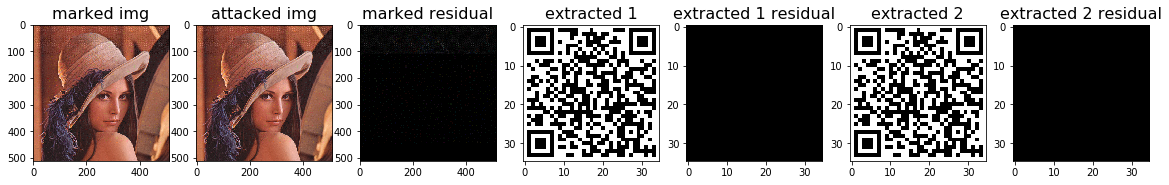

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


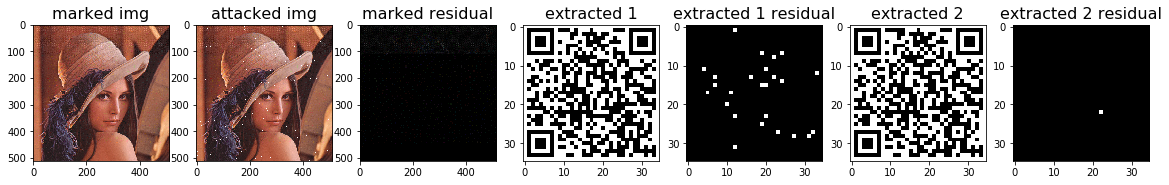

In [13]:
def hybrid_add_watermark(img, series, Q1=1000, Q2=1000):
    tmp_1 = DCT_add_watermark_corr(img, series, Q1)
    tmp_2 = spatial_add_watermark(tmp_1, series, Q2)
    return tmp_2


def hybrid_test(img, watermark, Q1=1000, Q2=1000, attack_method=no_attack, show=True, *args, **kwargs):
    series = qrcode2series(watermark)
    img_marked = hybrid_add_watermark(img, series, Q1, Q2)
    img_attacked = attack_method(img_marked, *args, **kwargs)
    series2_1 = spatial_extract_watermark(img_attacked, series.shape[0], Q1)
    reconstruct_1 = series2qrcode(series2_1)
    series2_2 = DCT_extract_watermark_corr(img_attacked, series.shape[0], Q2)
    reconstruct_2 = series2qrcode(series2_2)
    if show:
        fig = plt.figure(figsize=(20, 20))
        fig.add_subplot(1, 7, 1)
        plt.title("marked img", fontsize=16)
        plt.imshow(img_marked)
        fig.add_subplot(1, 7, 2)
        plt.title("attacked img", fontsize=16)
        plt.imshow(img_attacked)
        fig.add_subplot(1, 7, 3)
        plt.title("marked residual", fontsize=16)
        plt.imshow(np.abs(img_marked - img))
        fig.add_subplot(1, 7, 4)
        plt.title("extracted 1", fontsize=16)
        plt.imshow(reconstruct_1, cmap='gray')
        fig.add_subplot(1, 7, 5)
        plt.title("extracted 1 residual", fontsize=16)
        plt.imshow(np.abs(reconstruct_1 - watermark), cmap='gray')
        fig.add_subplot(1, 7, 6)
        plt.title("extracted 2", fontsize=16)
        plt.imshow(reconstruct_2, cmap='gray')
        fig.add_subplot(1, 7, 7)
        plt.title("extracted 2 residual", fontsize=16)
        plt.imshow(np.abs(reconstruct_2 - watermark), cmap='gray')
        plt.show()


_ = hybrid_test(img, binary_watermark, 10, 10)
_ = hybrid_test(img, binary_watermark, 10, 10, salt_pepper, True, *[1000, True])

# 批量测试

下面测试了在十种攻击下各个算法的稳健性。关注的指标主要是 MSE，PSNR 以及误码个数。可以得到如下的结论

- DCT_impose 和 DCT_corr 相对来说图像质量会降一些，但水印的稳健性大大提升，可以满足大部分需求
- DWT_DCT 稳健性相对较差，更适合于图像基本不失真的情形
- DCT_SVD 图像的质量显著好于其他的 DCT 方法，但稳健性不如 DCT_impose 和 DCT_corr
- 双边滤波相对来说还是比较难抵抗的

In [16]:
def test_single(img, watermark, encode_method, Q, attack_method, msg, *args, **kwargs):
    print_msg = []
    img_marked, reconstruct = encode_method(img, watermark, Q, attack_method, False, *args, **kwargs)
    print_msg.append(msg)
    print_msg.append(str(Q))
    print_msg.append(str(MSE(img, img_marked)))
    print_msg.append(str(PSNR(img, img_marked)))
    print_msg.append(str(np.sum(watermark != reconstruct)))
    print(','.join(print_msg))


def test(img, watermark, Q):
    attacks = [no_attack, salt_pepper, gaussian_attack, jpeg_attack, erase_attack,
               cv2.medianBlur, cv2.blur, cv2.GaussianBlur, cv2.bilateralFilter, hist_attack, color_attack]
    names = ["origin", "salt_pepper", "gaussian", "jpeg_attack", "erase_attack",
             "medianBlur", "blur", "GaussianBlur", "bilateralFilter", "hist_attack", "color_attack"]
    params = [[], [1000, True], [0.01], [], [], [3],
              [(3, 3)], [(3, 3), 0], [40, 75, 75], [], [0]]
    for i in range(len(attacks)):
        test_single(img, watermark, DCT_test,        Q,
                    attacks[i], "{0} + {1}".format(names[i], "DCT_test       "), *params[i])
        test_single(img, watermark, DCT_test_corr,   Q,
                    attacks[i], "{0} + {1}".format(names[i], "DCT_test_corr  "), *params[i])
        test_single(img, watermark, DCT_test_impose, Q,
                    attacks[i], "{0} + {1}".format(names[i], "DCT_test_impose"), *params[i])
        test_single(img, watermark, DWT_DCT_test,    Q,
                    attacks[i], "{0} + {1}".format(names[i], "DWT_DCT_test   "), *params[i])
        test_single(img, watermark, DCT_SVD_test,    Q,
                    attacks[i], "{0} + {1}".format(names[i], "DCT_SVD_test   "), *params[i])
        test_single(img, watermark, spatial_test,    Q,
                    attacks[i], "{0} + {1}".format(names[i], "spatial_test   "), *params[i])

_ = test(img, binary_watermark, 25)

origin + DCT_test       ,25,0.00012605156,43.562660627883254,0
origin + DCT_test_corr  ,25,0.00087038096,39.36685476534186,0
origin + DCT_test_impose,25,0.0010571921,38.94463231582133,0
origin + DWT_DCT_test   ,25,9.072689e-06,49.276721704620115,0
origin + DCT_SVD_test   ,25,1.8569381e-06,52.72141477912349,0
origin + spatial_test   ,25,4.164728e-05,45.96746862923288,0
salt_pepper + DCT_test       ,25,0.00012605156,43.562660627883254,7
salt_pepper + DCT_test_corr  ,25,0.00087038096,39.36685476534186,0
salt_pepper + DCT_test_impose,25,0.0010571921,38.94463231582133,0
salt_pepper + DWT_DCT_test   ,25,9.072689e-06,49.276721704620115,557
salt_pepper + DCT_SVD_test   ,25,1.8569381e-06,52.72141477912349,408
salt_pepper + spatial_test   ,25,4.164728e-05,45.96746862923288,24
gaussian + DCT_test       ,25,0.00012605156,43.562660627883254,0
gaussian + DCT_test_corr  ,25,0.00087038096,39.36685476534186,0
gaussian + DCT_test_impose,25,0.0010571921,38.94463231582133,0
gaussian + DWT_DCT_test   ,25,9

# Demo 展示

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


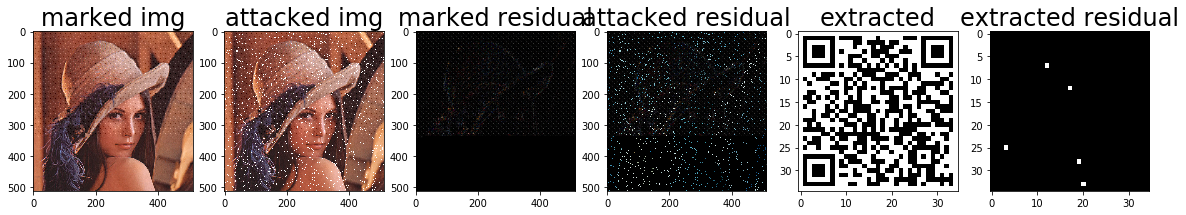

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


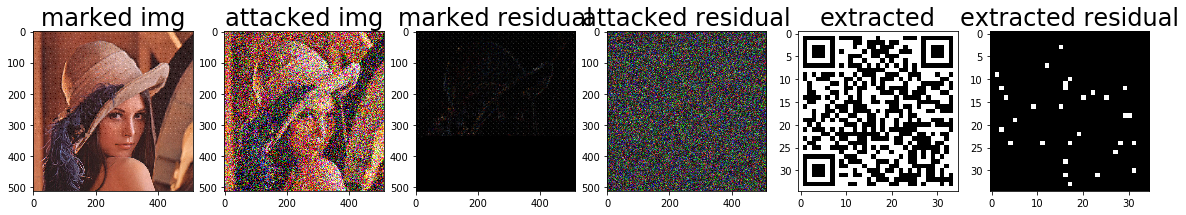

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


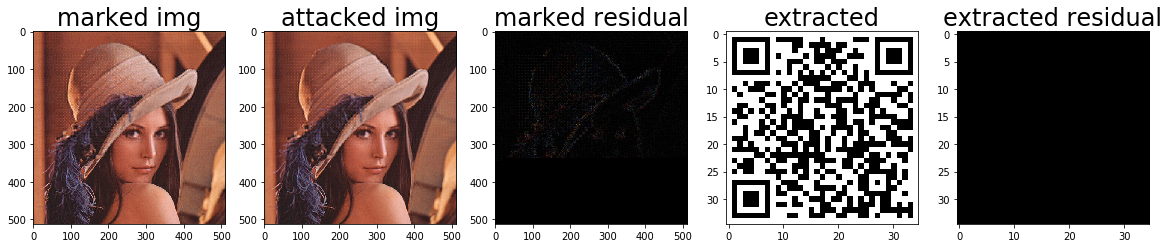

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


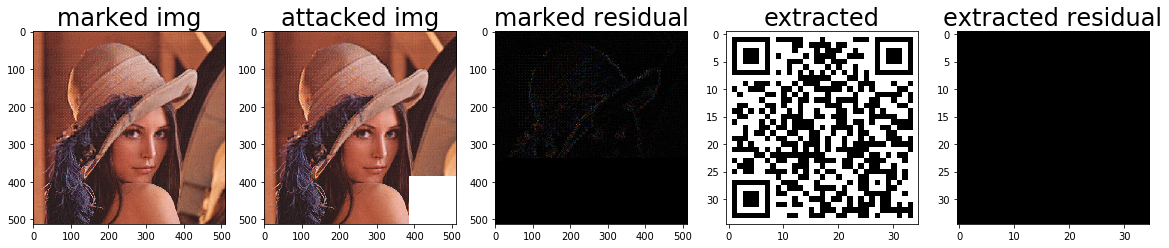

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


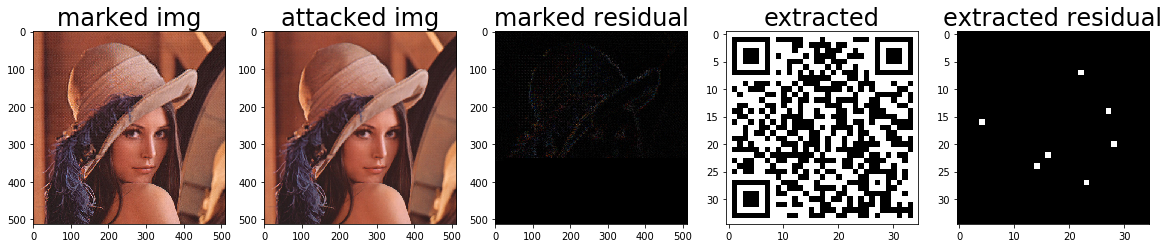

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


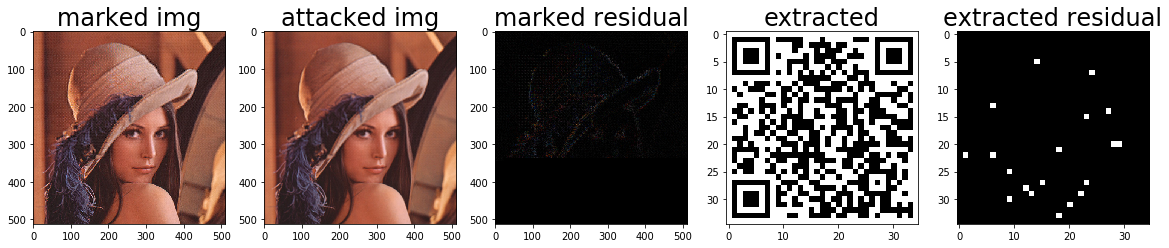

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


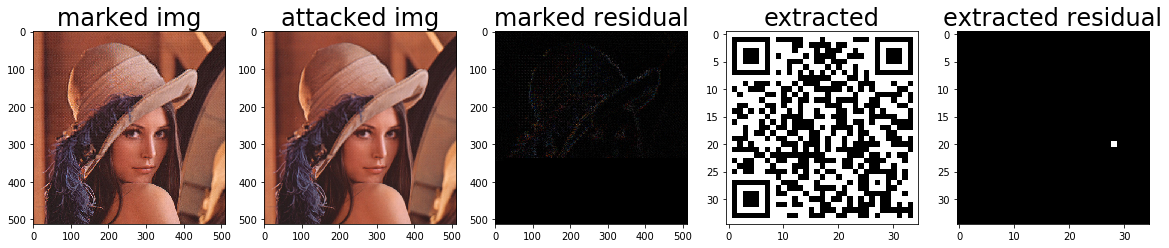

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


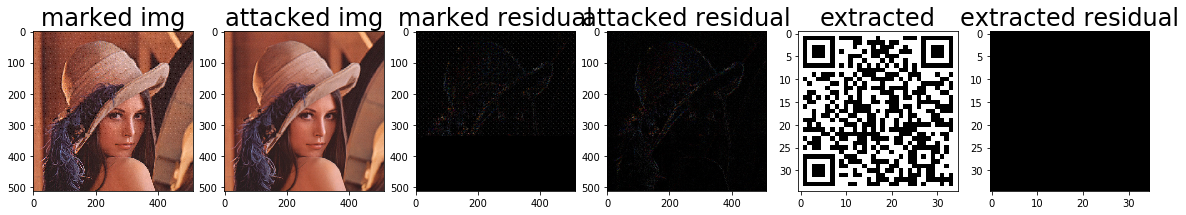

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


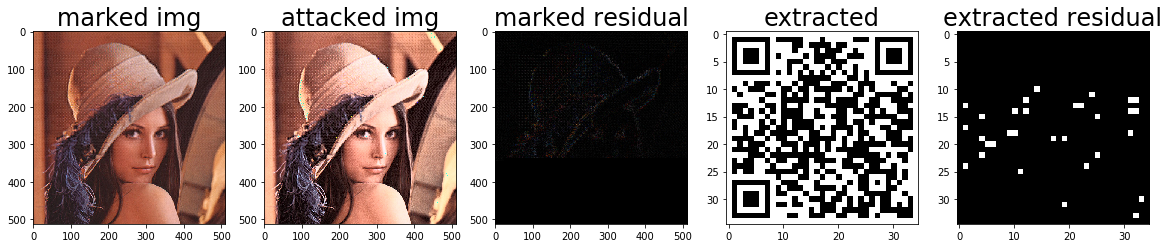

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


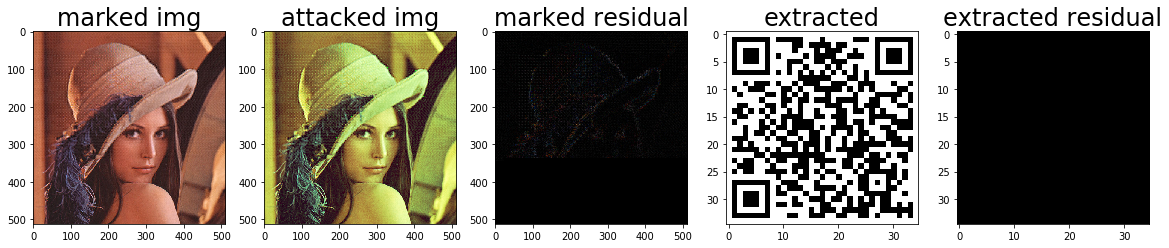

In [15]:
def demo():
    _ = DCT_test_impose(img, binary_watermark, 15, salt_pepper, True, *[10000, True])
    _ = DCT_test_impose(img, binary_watermark, 20, gaussian_attack, True, *[0.3])
    _ = DCT_test_corr(img, binary_watermark, 25, jpeg_attack, True, *[])
    _ = DCT_test_corr(img, binary_watermark, 25, erase_attack, True, *[])
    _ = DCT_test_corr(img, binary_watermark, 25,  cv2.medianBlur, True, *[3])
    _ = DCT_test_corr(img, binary_watermark, 25,  cv2.blur, True, *[(3, 3)])
    _ = DCT_test_corr(img, binary_watermark, 25, cv2.GaussianBlur, True, *[(3, 3), 0])
    _ = DCT_test_impose(img, binary_watermark, 25, cv2.GaussianBlur, True, *[(3, 3), 0])
    _ = DCT_test_corr(img, binary_watermark, 20, hist_attack, True, *[])
    _ = DCT_test_corr(img, binary_watermark, 20, color_attack, True, *[1])


demo()